In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import re

print("Tensorflow Version",tf.__version__)

Tensorflow Version 2.9.1


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arthurhain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('training_data.csv',encoding = 'latin',header=None)

In [3]:
df

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [4]:
df.columns = ['label', 'id', 'date', 'query', 'user_id', 'text']

In [5]:
df.drop(['id', 'date', 'query', 'user_id'], axis=1, inplace=True)

In [6]:
df = df.sample(frac=1).reset_index()

In [7]:
df.drop(['index'], axis=1, inplace=True)

### Changing Label values

In [8]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.label = df.label.apply(lambda x: label_decoder(x))
df.head()

,label,text
0,Negative,@squarespace Please let it be me. I don't yet...
1,Positive,@TomBeasley Michael McIntyre FTW
2,Negative,Ugh. Depressed. Just looked at my student reco...
3,Positive,followers on the rise
4,Positive,Vote for @suziperry : http://bit.ly/WnhrM th...


### Cleaning up the text

In [9]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [10]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [11]:
df.text = df.text.apply(lambda x: preprocess(x))

### Train Test Split

In [12]:
train, test = train_test_split(df, test_size=0.25, random_state=1)
print(train.shape[0])
print(test.shape[0])

1200000
400000


### Tokenization

In [13]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 278956


In [14]:
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

from keras_preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test.text),
                        maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1200000, 30)
Testing X Shape: (400000, 30)


In [15]:
labels = train.label.unique().tolist()

### Label Encoding

In [17]:
encoder = LabelEncoder()
encoder.fit(train.label.to_list())

y_train = encoder.transform(train.label.to_list())
y_test = encoder.transform(test.label.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1200000, 1)
y_test shape: (400000, 1)


### Word Embedding
Using a pre-trained embedding model instead of training it on our own. 

In [19]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-07-15 10:38:56--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-15 10:38:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-15 10:38:58--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [22]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [23]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [24]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [25]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            input_length=MAX_SEQUENCE_LENGTH,
                                            trainable=False)

### Model Training - LSTM

In [26]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [27]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

2022-07-15 10:47:00.549577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [29]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on CPU...


In [31]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=3,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/3
1172/1172 [==============================] - 846s 722ms/step - loss: 0.5076 - accuracy: 0.7484 - val_loss: 0.4802 - val_accuracy: 0.7674 - lr: 0.0010
Epoch 2/3
1172/1172 [==============================] - 965s 823ms/step - loss: 0.4856 - accuracy: 0.7636 - val_loss: 0.4707 - val_accuracy: 0.7731 - lr: 0.0010
Epoch 3/3
1172/1172 [==============================] - 1057s 902ms/step - loss: 0.4761 - accuracy: 0.7701 - val_loss: 0.4683 - val_accuracy: 0.7757 - lr: 0.0010


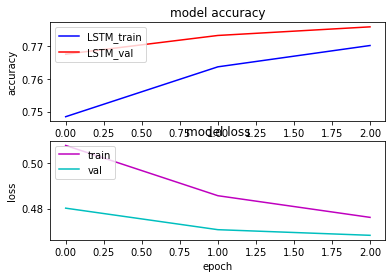

In [32]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [33]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

40/40 [==============================] - 47s 1s/step


In [37]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/pyplot.py'>

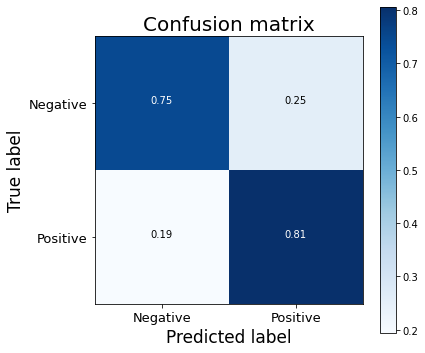

In [39]:
cnf_matrix = confusion_matrix(test.label.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test.label.unique(), title="Confusion matrix")
plt.show()

In [41]:
print(classification_report(list(test.label), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.79      0.75      0.77    199854
    Positive       0.76      0.81      0.78    200146

    accuracy                           0.78    400000
   macro avg       0.78      0.78      0.78    400000
weighted avg       0.78      0.78      0.78    400000



In [45]:
import pickle 

## Saving model on Pickle
filename = 'twitter_model.sav'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://c350dd74-3e4a-4874-83fa-307b939f5e27/assets


INFO:tensorflow:Assets written to: ram://c350dd74-3e4a-4874-83fa-307b939f5e27/assets


In [50]:
## Saving twitter tokenizer
filename_tokenizer = 'twitter_tokenizer.sav'
pickle.dump(tokenizer, open(filename_tokenizer, 'wb'))

In [51]:
model2 = pickle.load(open(filename, 'rb'))
tokenizer2 = pickle.load(open(filename_tokenizer, 'rb'))

In [47]:
scores = model2.predict(x_test, verbose=1, batch_size=10000)

40/40 [==============================] - 41s 1s/step


## For Zenyu: To import into applicaion

In [101]:
from keras_preprocessing.sequence import pad_sequences
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# For text cleaning: Removes certain characters
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)


def get_sentiment(model, tokenizer, tweets):
    tweet_df = pd.DataFrame(tweets, columns=['text'])
    tweet_df.text = tweet_df.text.apply(lambda x: preprocess(x))
    tweets_padded = pad_sequences(tokenizer.texts_to_sequences(tweet_df.text),
                        maxlen = 30)
    scores = model.predict(tweets_padded, verbose=1, batch_size=10000)

    total_score = 0
    for score in scores:
        total_score += score[0]

    # Getting label result by averaging out total_scores
    final_sentiment = total_score/len(scores)
    final_sentiment_text = ''
    if final_sentiment >= 0.5:
        print(final_sentiment)
        final_sentiment_text = 'Mostly Positive'
    else:
        print(final_sentiment)
        final_sentiment_text = 'Mostly Negative'

    return final_sentiment_text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arthurhain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Testing out the function

In [112]:
df2 = pd.read_csv('training_data.csv',encoding = 'latin',header=None)
df2.columns = ['label', 'id', 'date', 'query', 'user_id', 'text']
df2.drop(['id', 'date', 'query', 'user_id'], axis=1, inplace=True)
df2.sample(frac=1).reset_index()

,index,label,text
0,1056855,4,"@shineonmedia hey lisa, thanks for the #follow..."
1,1436030,4,"Apparently Zoe thinks the Condo is fabulous, s..."
2,1460137,4,morning. today is the big day. gots me shakin ...
3,1254992,4,"@DaveJMatthews watched the CBS segment, and th..."
4,1052602,4,"Thx for the #ff #followfriday - @JefferySelf, ..."
...,...,...,...
1599995,106320,0,My side is killing me
1599996,1470815,4,@sjayyy thanks darls. will update the site on ...
1599997,1295763,4,@babblingbrookie Happy Birthday! (It's my birt...
1599998,920873,4,@twishitter #poo the baby just had a successfu...


In [114]:
tweets

307697    @superjunk i just saw this (re: Schatje) too -...
307698            SRY I WAS PLAYIN GUITAR. GNITE @arielol  
307699    @Roy_from_it yessir. Nothing works. It vibrate...
307700         My eyes are leaking, i cant do this no more 
307701                                what happened??  haha
                                ...                        
399995           @omjchristinaaa awwwwe  i wish i was there
399996    @jonasbrothers Your YouTube channel has been s...
399997                         @Rray88 I don't get it  haha
399998    Wishing I was at OOC right now  didn't get to ...
399999                     @KRose82 oh... I miss the chick 
Name: text, Length: 92303, dtype: object

In [115]:
print(get_sentiment(model2, tokenizer2, tweets))

10/10 [==============================] - 7s 678ms/step
0.31080466477717955
Mostly Negative
